# Visualize Augmentations

In [1]:
import json
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

from src.data.visualize import drawRects
import src.data.augment as augment

data_path = "../data/Cricket-Semantic-Segmentation"
label_names = ["Batsmen", "Ball", "Wicket"]
classes = {}
with open(f"{data_path}/classes/classes.json") as handler:
    classes = json.load(handler)
    classes = list(map(lambda obj: {"name":obj["name"], "color": obj["color"]}, classes))
segments = list(filter(lambda name: "__fuse" in name, os.listdir(f"{data_path}/images")))
img_names = list(filter(lambda name: "__" not in name, os.listdir(f"{data_path}/images")))
labels = list(filter(lambda cls: cls["name"] in label_names, classes))
human_names = ["Bowler", "Batsmen", "Wicket Keeper", "Umpire", "Fielder"]
human_colors = list(map(lambda label: label["color"], list(filter(lambda cls: cls["name"] in human_names, classes))))

img_name = img_names[0]
seg_name = img_name + "___fuse.png"
txt_name = os.path.splitext(img_name)[0]+".txt"
txt_path = f"{data_path}/annotations/{txt_name}"
img_path = f"{data_path}/images/{img_name}"
seg_path = f"{data_path}/images/{seg_name}"
txt_boxes = ""
with open(txt_path) as handler:
    txt_boxes = handler.read()
img = cv.imread(img_path)
seg = cv.imread(seg_path)
drawn_img = drawRects(img, txt_boxes)

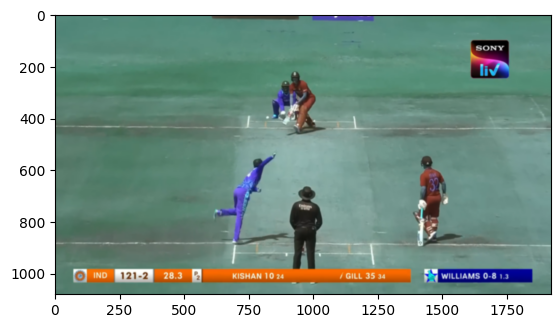

In [2]:
blur_img = augment.blur(img)
plt.imshow(blur_img)
plt.show()

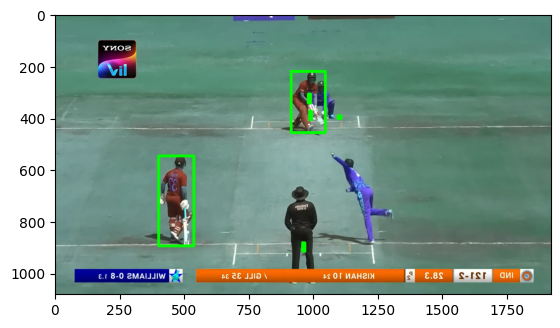

True


In [6]:
aug_img, boxes, flipped = augment.horizontal_flip(img, txt_boxes)
drawn_aug_img = drawRects(aug_img, boxes)
plt.imshow(drawn_aug_img)
plt.show()
print(flipped)

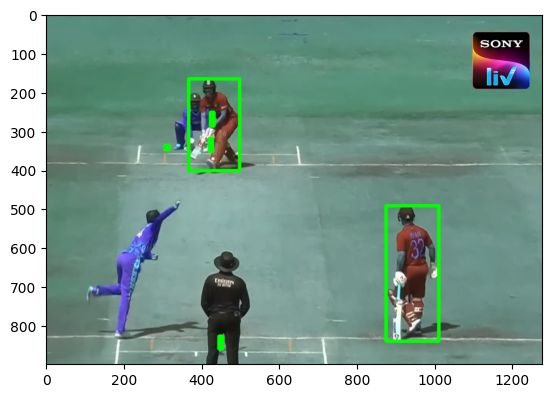

In [51]:
aug_img, boxes, crop_data = augment.DSSC(img, txt_boxes, visualize=False)
drawn_aug_img = drawRects(aug_img, boxes)
plt.imshow(drawn_aug_img)
plt.show()

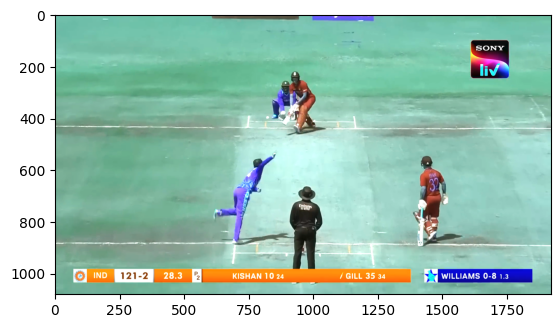

In [3]:
adjusted_img = augment.brightness_contrast(img)
plt.imshow(adjusted_img)
plt.show()

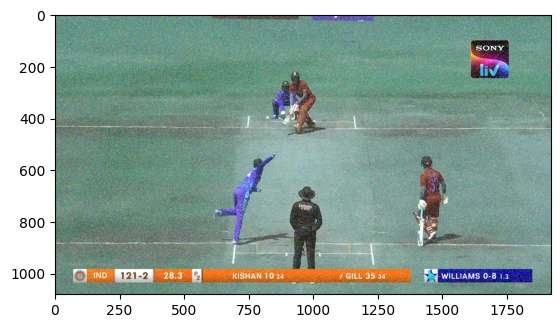

In [6]:
gn_img = augment.noise(img)
plt.imshow(gn_img)
plt.show()

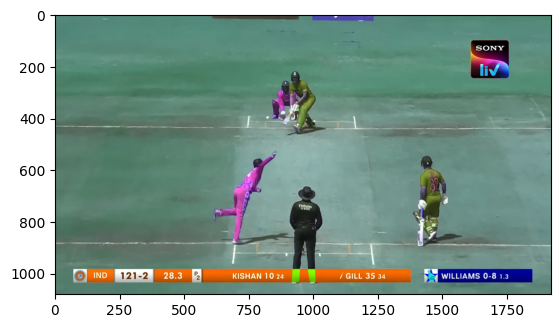

In [3]:
adjusted_img = augment.rotate_hue(img, seg)
plt.imshow(adjusted_img)
plt.show()

# Create Dataset

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
!rm -r sample_data
!cp -r /content/drive/MyDrive/IIT-Projects/third-umpire-decision-automation/.creds/.aws ~/
!cp -r /content/drive/MyDrive/IIT-Projects/third-umpire-decision-automation/backend/experiments/src ./

In [ ]:
!pip install -qq sagemaker

In [ ]:
from src.data.download import download
from src.data.process import segmentationDS2DetectionDS

ds_path = download("cricket-semantic")
segmentationDS2DetectionDS(ds_path)

In [1]:
import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

import src.data.augment as augment
from src.data.process import splitForObjectDetect

In [2]:
batsman_emphasis = [13,30,32,67,68,87,88,89,99,115,117,118,119,120,121,166,237,279,280,281,282,325,326,327,344]
wicket_emphasis = [13,14,30,32,67,68,87,88,89,90,115,117,119,166,237,326,327,344]
delete_nums = [236,328]
emphasis_nums = list(set(batsman_emphasis).union(set(wicket_emphasis)))
total_raw_data_count = 298
emphasis_weight = 10
augment_rounds = 3

In [3]:
original_data_path = "../data/Cricket-Semantic-Segmentation"
augment_data_path = "../data/Cricket-Semantic-Segmentation-Augmented"

augment.create_dataset(
    original_data_path,
    augment_data_path,
    total_raw_data_count,
    delete_nums,
    emphasis_nums,
    augment_rounds,
    emphasis_weight,
)

---- Validating Raw Data ----


  0%|          | 0/296 [00:00<?, ?it/s]

---- Creating New Data ----


  0%|          | 0/1913 [00:00<?, ?it/s]

In [4]:
train_weight = 7
val_weight = 2
splited_augmented_path = f"{augment_data_path}[Splitted]"
splitForObjectDetect(augment_data_path, train_weight, val_weight, splited_augmented_path)

In [ ]:
from sagemaker.s3 import S3Uploader
s3_uri = "s3://third-umpire-decision-automation-osura/datasets/object-segment-augmented-dataset"
S3Uploader.upload(splited_augmented_path, s3_uri)